In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import corner

In [2]:
%config InlineBackend.figure_format = 'retina'

This notebook demonstrates building a normalizing flow to learn the multi-dimensional space of galaxy magnitudes and redshifts.

I used the FlaxNormalizingFlow class, which takes a flax module and data transformation, and has sample, log_prob, and train methods. You can create your own normalizing flow in flax and swap it out for the RQNeuralSplineFlow I use, or define your own data transformation (and it's inverse), and wrap it in the same class.

Contents:
1. Loading the data and defining a transformation on the data for use with the normalizing flow
2. Creating and training a normalizing flow
3. Saving and loading a normalizing flow
4. Plotting the distribution learned by the flow

### 1. Galaxy Data

In [3]:
import pandas as pd
from catalogLoader import catalogLoader
from sklearn.model_selection import train_test_split

Load the galaxy data

In [4]:
# load the catalog data
data = catalogLoader('sample_catalog_config.yaml').get_catalog_mags_and_redshift()

# rename and reorder columns for readability
data = data.rename(columns={'redshift_true' : 'redshift',
                            'mag_true_u_lsst' : 'u',
                            'mag_true_g_lsst' : 'g',
                            'mag_true_r_lsst' : 'r',
                            'mag_true_i_lsst' : 'i',
                            'mag_true_z_lsst' : 'z',
                            'mag_true_y_lsst' : 'y'})
data = data.reindex(columns=['redshift', 'u', 'g', 'r', 'i', 'z', 'y'])

Apply bias

In [5]:
np.random.seed(0)
pivot_redshift = 0.8
probs = np.clip(pivot_redshift/data['redshift'], 0, 1)
idx = np.where(np.random.uniform(size=len(data)) <= probs)
biased_data = data.iloc[idx]

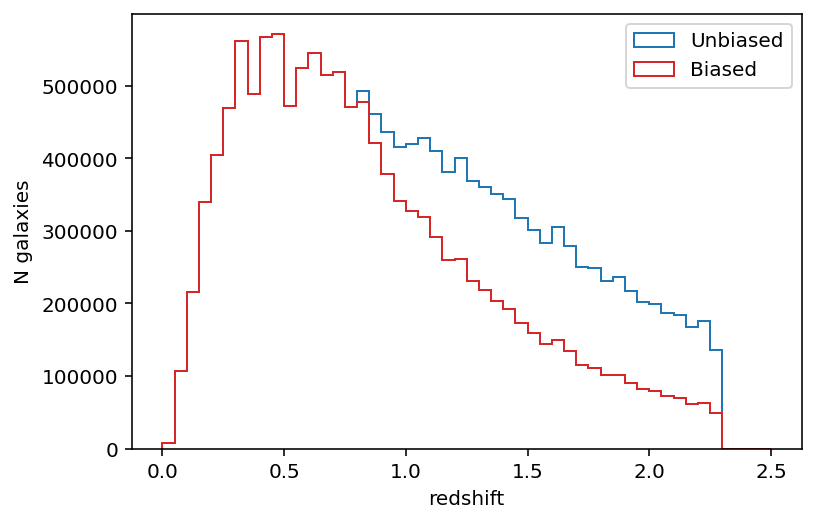

In [6]:
plt.hist(data['redshift'], bins=50, range=(0,2.5), histtype='step', color='C0', label='Unbiased')
plt.hist(biased_data['redshift'], bins=50, range=(0,2.5), histtype='step', color='C3', label='Biased')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('N galaxies')
plt.show()

In [7]:
del data

Split data into training and test sets. The normalizing flow will be trained on the training set and the test set will be used to evaluate the validation loss.

In [8]:
# split training and test set
trainingset, testset = train_test_split(biased_data, train_size=0.8, random_state=0)

Now we want to transform the data before giving it to the normalizing flow. Instead of directly using galaxy magnitudes, we want to use colors. In addition, we provide a normalized $r$ magnitude as proxy for overall galaxy magnitude.

We need to define this data transform (and it's inverse) so we can give it to the normalizing flow. 
This allows us to work in the space of galaxy magnitudes while the flow works in the space of galaxy colors.

In [10]:
r_mag_mean = np.mean(trainingset['r'])
r_mag_stdd = np.std(trainingset['r'])

def transform_data(data):
    """
    Function that maps from galaxy magnitude space to galaxy color space,
    which is the space that the normalizing flow works in.
    """
    trans_data = pd.DataFrame()
    trans_data['redshift'] = data['redshift'].copy()
    trans_data['r_mag_normalized'] = (data['r'] - r_mag_mean)/r_mag_stdd
    trans_data['u-g'] = data['u'] - data['g'] 
    trans_data['g-r'] = data['g'] - data['r'] 
    trans_data['r-i'] = data['r'] - data['i'] 
    trans_data['i-z'] = data['i'] - data['z'] 
    trans_data['z-y'] = data['z'] - data['y'] 
    
    return trans_data

def inv_transform_data(trans_data):
    """
    Function that maps from galaxy color space to galaxy magnitude space.
    This allows us to map flow samples to data samples.
    """
    
    # trans_data = [redshift, r_mag_normalized,
    #                   u-g, g-r, r-i, i-z, z-y]
    
    if isinstance(trans_data, pd.DataFrame):
        trans_data = np.array(trans_data)
    
    data = pd.DataFrame()
    data['redshift'] = trans_data[:,0]
    
    r = trans_data[:,1] * r_mag_stdd + r_mag_mean
    
    data['u'] = r + trans_data[:,3] + trans_data[:,2]
    data['g'] = r + trans_data[:,3]
    data['r'] = r
    data['i'] = data['r'] - trans_data[:,4]
    data['z'] = data['i'] - trans_data[:,5]
    data['y'] = data['z'] - trans_data[:,6]
    
    return data

Here is an example of the data, the data transformation, and the inverse transformation:

In [11]:
# original data
data_ex = trainingset.head()
data_ex

,redshift,u,g,r,i,z,y
9984254,1.001113,25.056698,24.880240,24.540962,24.043061,23.566710,23.389901
5784595,1.852460,27.701078,27.192865,26.713096,26.359199,25.829003,25.574374
7605617,1.418048,26.649472,25.788254,25.143026,24.422756,24.075931,23.435756
4446803,0.477916,25.541953,24.989324,24.243693,24.025309,23.913516,23.751632
1754008,0.288123,28.054874,27.302556,26.675832,26.461097,26.285143,26.232133


In [12]:
# transformed data
trans_data_ex = transform_data(data_ex)
trans_data_ex

,redshift,r_mag_normalized,u-g,g-r,r-i,i-z,z-y
9984254,1.001113,-0.492833,0.176457,0.339278,0.497901,0.476351,0.176810
5784595,1.852460,0.993066,0.508212,0.479769,0.353897,0.530196,0.254628
7605617,1.418048,-0.080977,0.861218,0.645228,0.720270,0.346825,0.640175
4446803,0.477916,-0.696188,0.552629,0.745632,0.218383,0.111793,0.161884
1754008,0.288123,0.967575,0.752318,0.626724,0.214735,0.175954,0.053010


In [13]:
# inverse transforming the transformed data
# should match the original!
inv_transform_data(trans_data_ex)

,redshift,u,g,r,i,z,y
0,1.001113,25.056698,24.880240,24.540962,24.043061,23.566710,23.389901
1,1.852460,27.701078,27.192865,26.713096,26.359199,25.829003,25.574374
2,1.418048,26.649472,25.788254,25.143026,24.422756,24.075931,23.435756
3,0.477916,25.541953,24.989324,24.243693,24.025309,23.913516,23.751632
4,0.288123,28.054874,27.302556,26.675832,26.461097,26.285143,26.232133


### 2. Training a Normalizing Flow

Now we want to build a normalizing flow to learn the multidimensional space of colors and redshifts.

We are using a [real NVP](https://arxiv.org/abs/1605.08803) with [Rational Quadratic Splines](http://arxiv.org/abs/1906.04032) in the coupling layers.

In [14]:
%load_ext autoreload
%autoreload 2

from rqNeuralSplineFlow import RQNeuralSplineFlow
from normalizingFlow import NormalizingFlow

# will want this activation function below
from flax.nn import leaky_relu

Set the hyperparameters. The comments above each block tell you at which level the hyperparameters are defined.

In [15]:
hyperparams = {
    # FlaxNormalizingFlow
    'nfeatures' : 7,

    # RQNeuralSplineFlow
    'nlayers' : 7,
    'nbins' : 32,

    # RQNeuralSplineCoupling
    'coupling_range' : 1,
    'coupling_dim' : 128,
    'coupling_layers' : 3,
    'coupling_activation': leaky_relu
}

Now let's create the normalizing flow using our `FlaxNormalizingFlow` class. We have to tell give it the Flax module that defines the flow, the dictionary of hyperparameters, and the data transforms. It returns a normalizing flow object that has the following methods: `flow.sample(n_samples)`, `flow.log_prob(x)`, and `flow.train(trainingset)`.


In [16]:
flow = NormalizingFlow(RQNeuralSplineFlow, hyperparams, 
                        transform_data=transform_data,
                        inv_transform_data=inv_transform_data)

Now let's train the flow.

In [17]:
%%time 
losses, testlosses = flow.train(trainingset, testset, batch_size=1024, seed=0, return_losses=True, verbose=True)

9.096861
-0.11341684
-2.2498837
-2.6940844
-3.5698392
-4.484426
-4.182757
-4.4399395
-4.909548
-4.0689664
-3.7981164
-4.9762135
-4.150546
-5.6322303
-4.5944777
-5.558757
-5.3356013
-5.6594186
-5.2413893
-5.9425592
-5.5331836
CPU times: user 1h 1min 56s, sys: 10min 8s, total: 1h 12min 4s
Wall time: 29min 31s


Let's plot the training losses

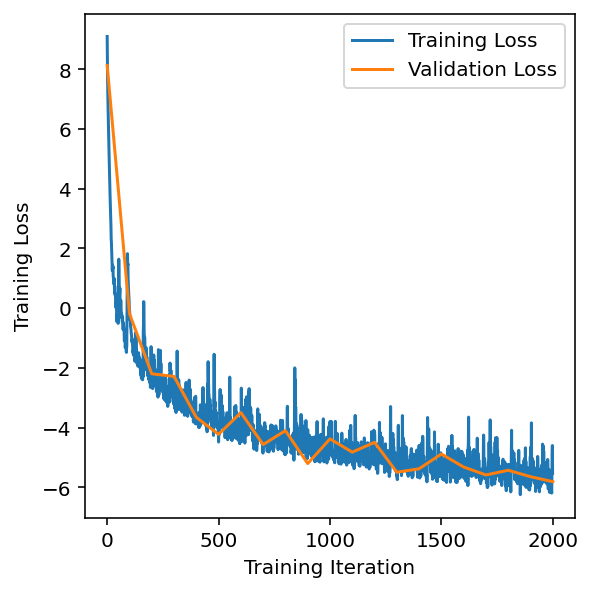

In [18]:
fig = plt.figure(figsize=(4,4), constrained_layout=True)

x = np.arange(len(losses))
plt.plot(x, losses, c='C0', label='Training Loss')

x = np.arange(0, len(losses)+100, 100)
plt.plot(x, testlosses, c='C1', label='Validation Loss')

plt.legend()
plt.xlabel("Training Iteration")
plt.ylabel("Training Loss")
plt.show()

### 3. Saving and Loading a Normalizing Flow

Let's save this flow

In [19]:
flow.save('biased_flow.pkl')

This is how you load a flow from a file

In [20]:
flow = NormalizingFlow(RQNeuralSplineFlow, file='biased_flow.pkl')

### 4. Plotting the Learned Distribution

Here is a corner plot of the results. Blue is truth, red is the flow's prediction.

In [21]:
n_samples = 10000
samples = flow.sample(n_samples, seed=0)
testbatch = testset.sample(n=n_samples, random_state=0)

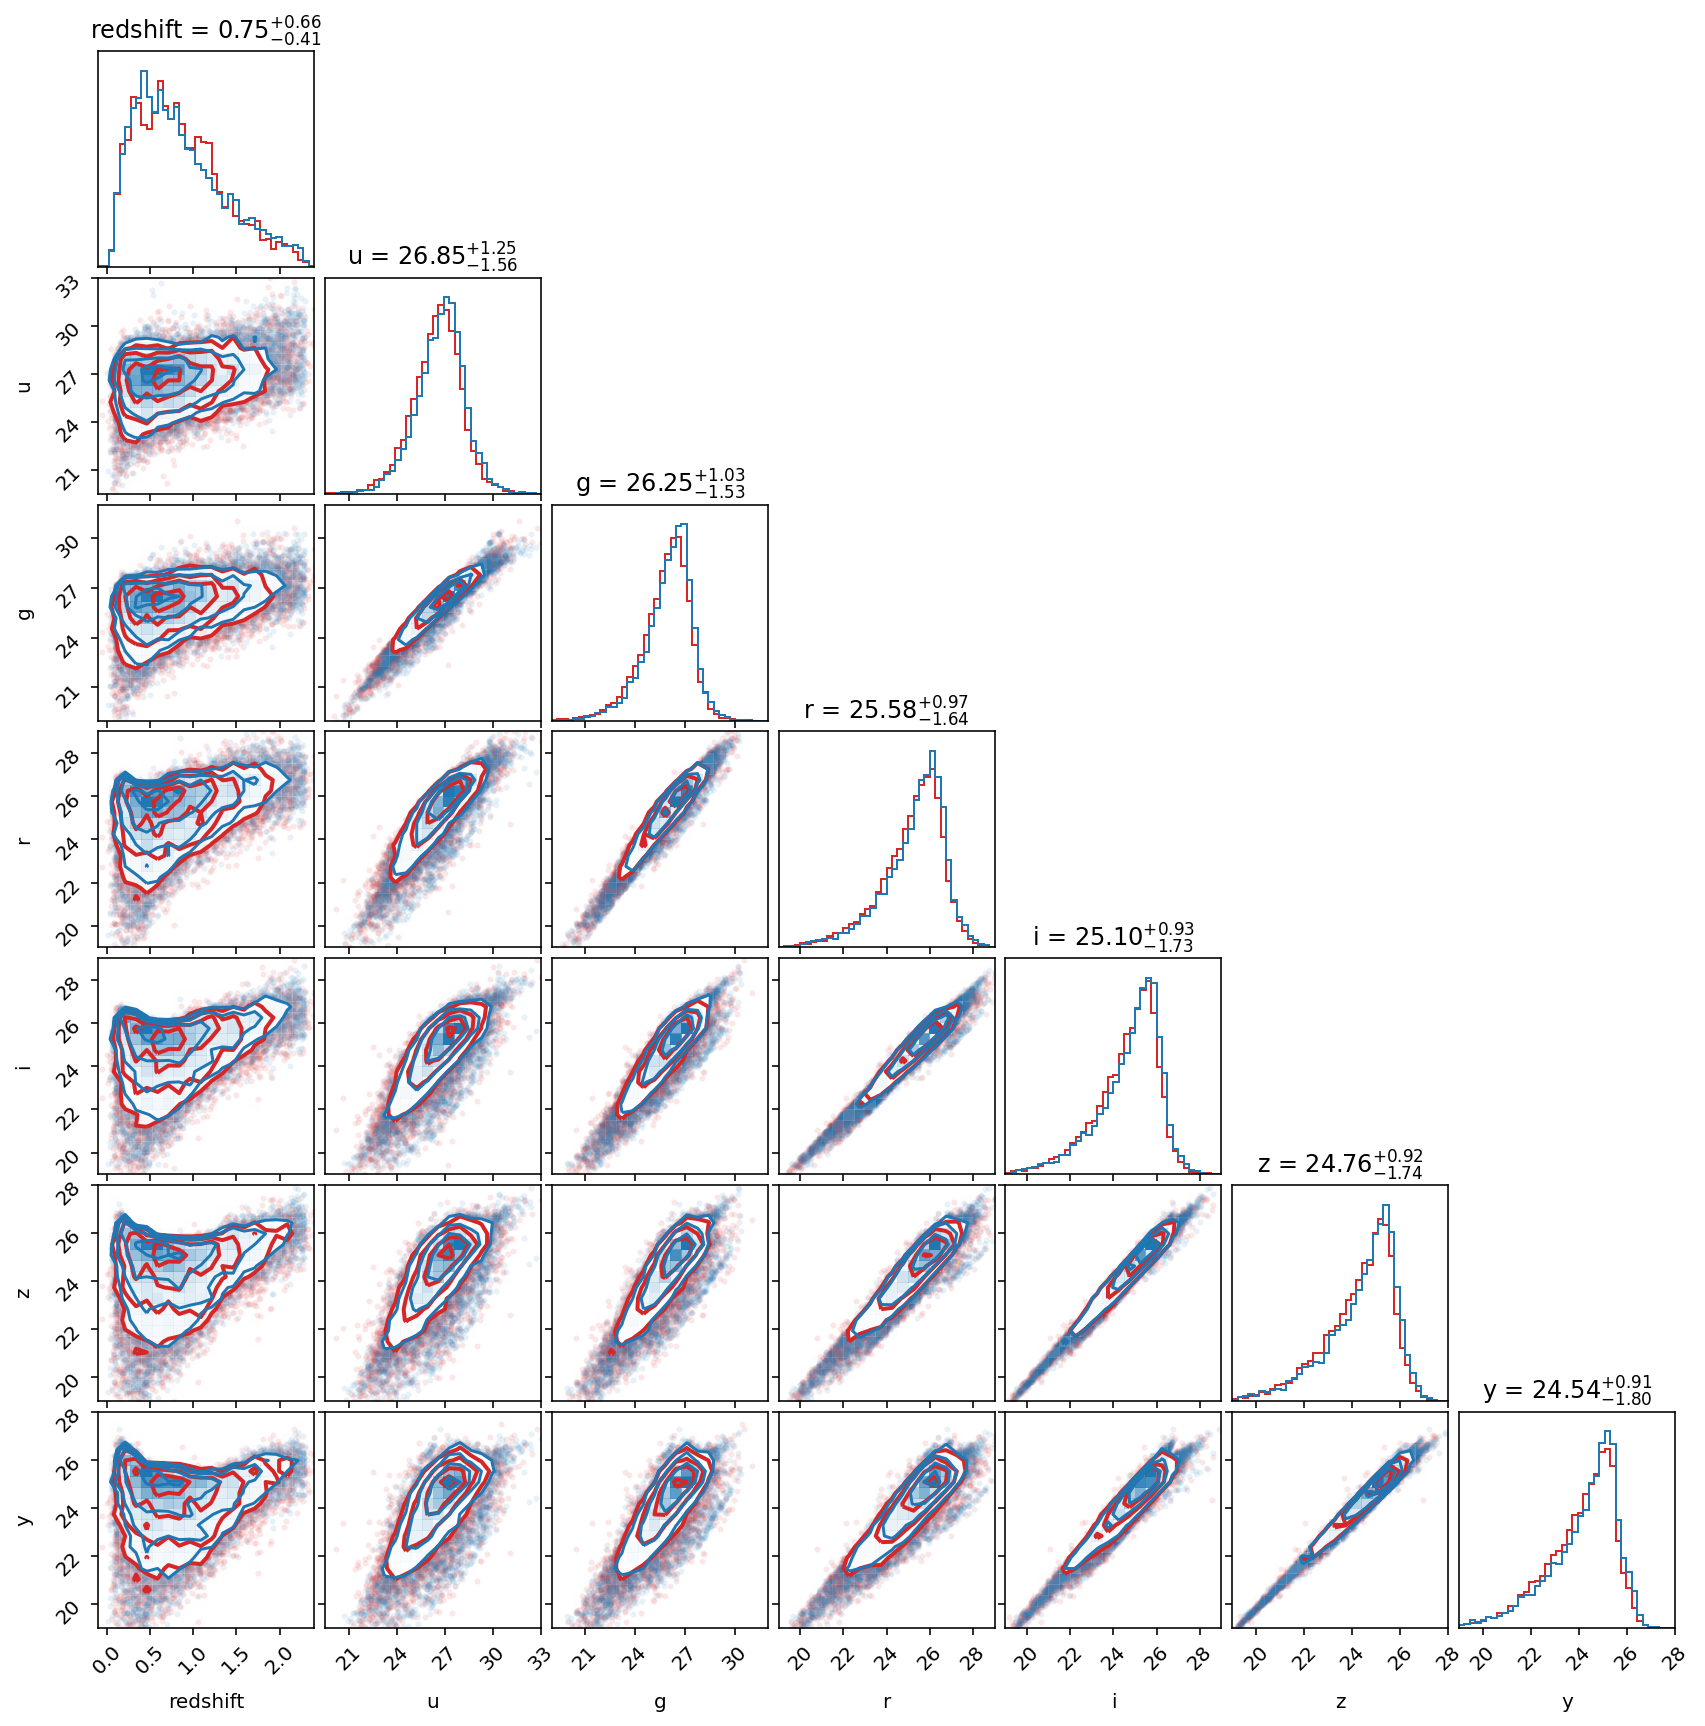

In [23]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

testbatch = testset.sample(n=10000, random_state=0)
corner.corner(testbatch, fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);